<a href="https://colab.research.google.com/github/IdjiotSandwiches/face-emotion-recognition/blob/knn-model/machine-learning/knn-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dagshub --quiet
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/

In [1]:
import cv2 as cv
import numpy as np
import mlflow
import dagshub
import os
import pathlib
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pickle

In [2]:
PATH = pathlib.Path('C:\\Users\\vinar\\Downloads\\FER2013-augmented')
LABELS = os.listdir(PATH)

In [3]:
dagshub.init(repo_owner='IdjiotSandwiches', repo_name='face-emotion-recognition', mlflow=True)

Accessing as IdjiotSandwiches

Initialized MLflow to track repo "IdjiotSandwiches/face-emotion-recognition"

Repository IdjiotSandwiches/face-emotion-recognition initialized!

In [4]:
K_SIZE = (21,21)
SIGMA = 3
THETA_RANGE = np.arange(0, np.pi, np.pi/32)
LAMBD = 10.0
GAMMA = 0.5
PSI = 0
FLOATING_POINT = cv.CV_32F
IMAGE_SIZE = (224,224)
N_COMPONENTS = 0.95
N_COMPONENTS_LOCAL = 16
BLUR = (5,5)

gabor_params = {
    'ksize': K_SIZE,
    'sigma': SIGMA,
    'lambd': LAMBD,
    'gamma': GAMMA,
    'psi': PSI
}

KERNELS = [cv.getGaborKernel(**gabor_params, theta=theta) for theta in THETA_RANGE]

In [5]:
def gabor_filter(img):
  img = img.astype(np.float32)
  return np.array([cv.filter2D(img, FLOATING_POINT, kernel) for kernel in KERNELS])

In [54]:
def save_filtered_img(images, labels, path):
  folder_path = f'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\{path}'
  os.makedirs(folder_path, exist_ok=True)

  np.save(f'{folder_path}/images.npy', images)
  np.save(f'{folder_path}/labels.npy', labels)

  print('Ok!')

In [55]:
from joblib import Parallel, delayed

def process_image(img_path, label, dir):
    """
    Process a single image: read, preprocess, and apply PCA.
    """
    path = f'{dir}/{label}'
    img = cv.imread(f'{path}/{img_path}', 0)
    img = cv.resize(img, IMAGE_SIZE)
    img = cv.GaussianBlur(img, BLUR, 0)
    img = cv.equalizeHist(img)

    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        img = img[y:y+h, x:x+w]
    else:
        h, w = img.shape[:2]
        crop_size = min(h, w)
        x = (w - crop_size) // 2
        y = (h - crop_size) // 2
        img = img[y:y+crop_size, x:x+crop_size]
    
    img = cv.copyMakeBorder(
        img, 
        10, 10, 10, 10,
        cv.BORDER_CONSTANT, 
        value=(0, 0, 0)
    )
    
    img = cv.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = gabor_filter(img)

    img = img.reshape(img.shape[0], -1)
    pca = PCA(n_components=N_COMPONENTS_LOCAL)
    img = pca.fit_transform(img)

    folder_path = f'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\new\\{label}'
    os.makedirs(folder_path, exist_ok=True)
    img_path = img_path.split('.')
    np.save(f'{folder_path}/{img_path[0]}.npy', img)


def open_dataset(dir):
    """
    Open dataset, load images, preprocess, and return images and labels using parallel processing.
    """
    # Use Parallel from joblib to process images in parallel
    results = Parallel(n_jobs=4)(delayed(process_image)(img_path, label, dir)
                                   for label in LABELS
                                   for img_path in tqdm(os.listdir(f'{dir}/{label}')))

    # Unzip the results into images and labels
    # images, labels = zip(*results)

    # return np.array(images), np.array(labels)

In [56]:
images, labels = open_dataset(PATH)
# save_filtered_img(images, labels, 'FER2013/new')

100%|██████████| 12000/12000 [10:46<00:00, 18.57it/s]


TypeError: cannot unpack non-iterable NoneType object

In [57]:
images = []
labels = []
folder = 'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\new'
LABELS = os.listdir(folder)
for label in LABELS:
    class_folder = f'{folder}/{label}'
    for img_path in tqdm(os.listdir(class_folder)):
        img = np.load(f'{class_folder}/{img_path}')
        images.append(img)
        labels.append(label)

  0%|          | 0/12000 [00:00<?, ?it/s]

100%|██████████| 12000/12000 [01:15<00:00, 158.79it/s]


In [59]:
images = np.array(images)
labels = np.array(labels)

In [60]:
images = images.reshape(images.shape[0], -1)
pca = PCA(n_components=N_COMPONENTS)
images_ = pca.fit_transform(images)

with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
print(images_.shape)

Explained variance ratio: [0.6165531  0.12701143 0.09969416 0.07283828 0.02510052 0.01686663]
Cumulative explained variance: [0.6165531  0.74356455 0.8432587  0.9160969  0.94119745 0.9580641 ]
(72000, 6)


In [61]:
save_filtered_img(images_, labels, 'FER2013/combined')

Ok!


## **Testing**

Accuracy: 0.4244047619047619
Precision: 0.42548824039956323
Recall: 0.42440476190476195
F1 Score: 0.4245016671341147
AUC Score: 0.7150301870748299
              precision    recall  f1-score   support

       angry       0.42      0.43      0.43       840
        fear       0.39      0.45      0.42       840
       happy       0.40      0.38      0.39       840
     neutral       0.46      0.44      0.45       840
         sad       0.41      0.41      0.41       840
    surprise       0.46      0.44      0.45       840

    accuracy                           0.42      5040
   macro avg       0.43      0.42      0.42      5040
weighted avg       0.43      0.42      0.42      5040



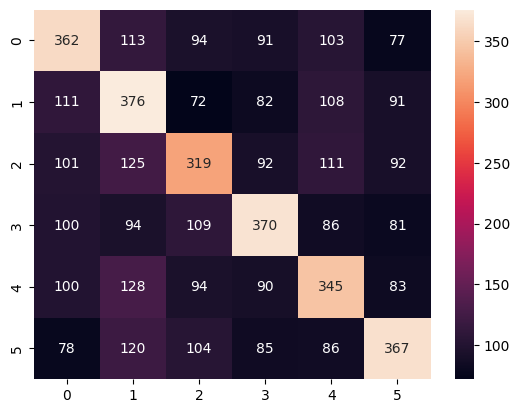

2024/12/18 23:05:35 INFO mlflow.tracking.fluent: Experiment with name 'KNN_Model FER2013 224x224' does not exist. Creating a new experiment.


🏃 View run KNN StratifiedKFold=0 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/a27ade2f3f2a4a319ad1296840626189
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.4307539682539683
Precision: 0.43107125478469904
Recall: 0.4307539682539683
F1 Score: 0.43069962268429623
AUC Score: 0.7226573601662887
              precision    recall  f1-score   support

       angry       0.42      0.45      0.44       840
        fear       0.43      0.41      0.42       840
       happy       0.42      0.43      0.43       840
     neutral       0.43      0.41      0.42       840
         sad       0.41      0.42      0.42       840
    surprise       0.47      0.46      0.47       840

    accuracy                           0.43      5040
   macro avg       0.43      0.43      0.43      5040
weighted avg       0.43      0.43      0.43      5040



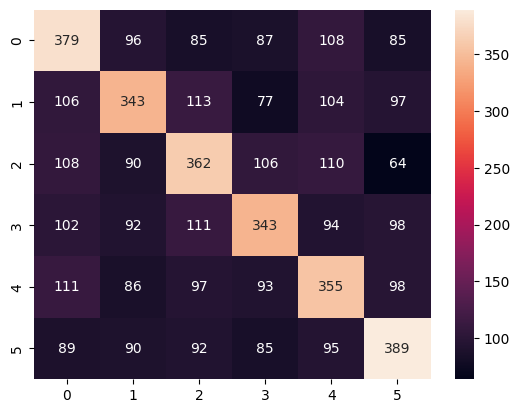

🏃 View run KNN StratifiedKFold=1 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/b66190ecffd740e7a5d075a29fdab154
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.4384920634920635
Precision: 0.4403126921559792
Recall: 0.4384920634920635
F1 Score: 0.43867571303688613
AUC Score: 0.7272105536659108
              precision    recall  f1-score   support

       angry       0.41      0.39      0.40       840
        fear       0.48      0.44      0.46       840
       happy       0.41      0.47      0.44       840
     neutral       0.41      0.45      0.43       840
         sad       0.45      0.42      0.43       840
    surprise       0.48      0.47      0.47       840

    accuracy                           0.44      5040
   macro avg       0.44      0.44      0.44      5040
weighted avg       0.44      0.44      0.44      5040



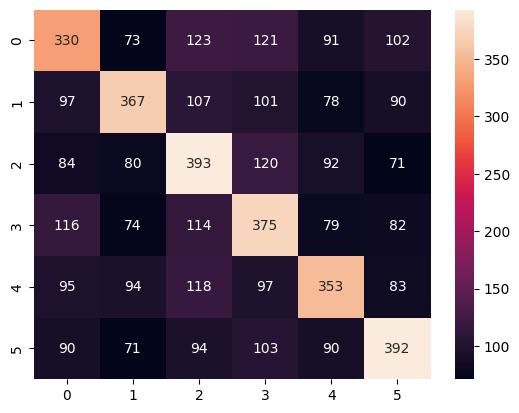

🏃 View run KNN StratifiedKFold=2 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/178c1c53550848359b1581bfcf01001b
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.4234126984126984
Precision: 0.4239907194667993
Recall: 0.4234126984126984
F1 Score: 0.4234993198866103
AUC Score: 0.7226694066515496
              precision    recall  f1-score   support

       angry       0.40      0.41      0.41       840
        fear       0.43      0.40      0.41       840
       happy       0.43      0.43      0.43       840
     neutral       0.39      0.41      0.40       840
         sad       0.43      0.42      0.43       840
    surprise       0.47      0.47      0.47       840

    accuracy                           0.42      5040
   macro avg       0.42      0.42      0.42      5040
weighted avg       0.42      0.42      0.42      5040



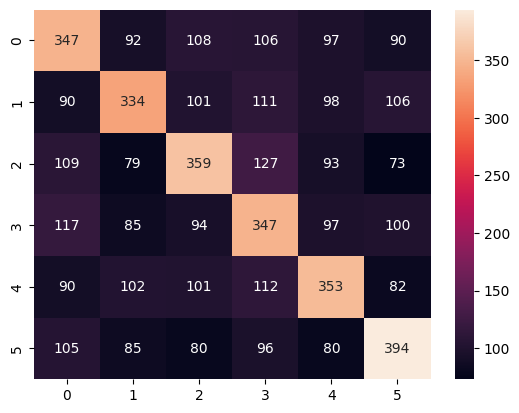

🏃 View run KNN StratifiedKFold=3 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/fe0c2c14b7054f04bc668bda9fbdf4d6
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.42123015873015873
Precision: 0.4216607614970395
Recall: 0.4212301587301588
F1 Score: 0.4212890661007733
AUC Score: 0.7155355725623581
              precision    recall  f1-score   support

       angry       0.41      0.42      0.42       840
        fear       0.41      0.40      0.41       840
       happy       0.42      0.41      0.41       840
     neutral       0.44      0.42      0.43       840
         sad       0.41      0.44      0.42       840
    surprise       0.45      0.43      0.44       840

    accuracy                           0.42      5040
   macro avg       0.42      0.42      0.42      5040
weighted avg       0.42      0.42      0.42      5040



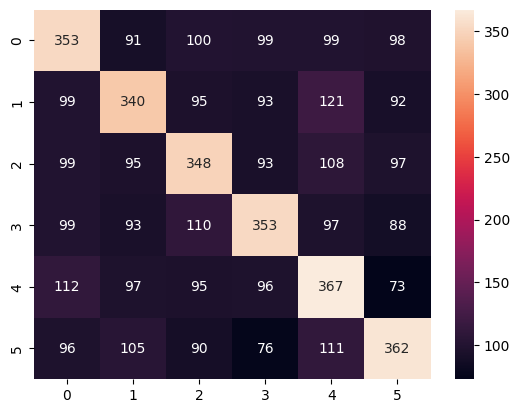

🏃 View run KNN StratifiedKFold=4 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/3de8c110ec73464c93b426f5190da13c
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.4371031746031746
Precision: 0.43727492535517487
Recall: 0.4371031746031746
F1 Score: 0.43699287241951795
AUC Score: 0.7253337585034013
              precision    recall  f1-score   support

       angry       0.45      0.43      0.44       840
        fear       0.44      0.42      0.43       840
       happy       0.42      0.42      0.42       840
     neutral       0.44      0.44      0.44       840
         sad       0.43      0.43      0.43       840
    surprise       0.44      0.47      0.45       840

    accuracy                           0.44      5040
   macro avg       0.44      0.44      0.44      5040
weighted avg       0.44      0.44      0.44      5040



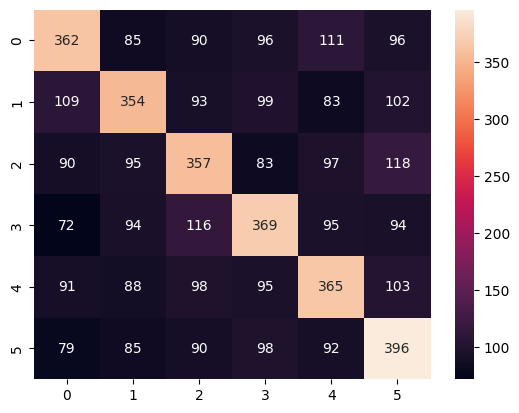

🏃 View run KNN StratifiedKFold=5 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/445b25a59381489eae7cd8549d117bf6
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.42083333333333334
Precision: 0.42125349139504825
Recall: 0.4208333333333334
F1 Score: 0.4208040365288879
AUC Score: 0.7150753495842782
              precision    recall  f1-score   support

       angry       0.42      0.43      0.43       840
        fear       0.43      0.41      0.42       840
       happy       0.42      0.41      0.42       840
     neutral       0.40      0.43      0.42       840
         sad       0.44      0.41      0.42       840
    surprise       0.42      0.43      0.43       840

    accuracy                           0.42      5040
   macro avg       0.42      0.42      0.42      5040
weighted avg       0.42      0.42      0.42      5040



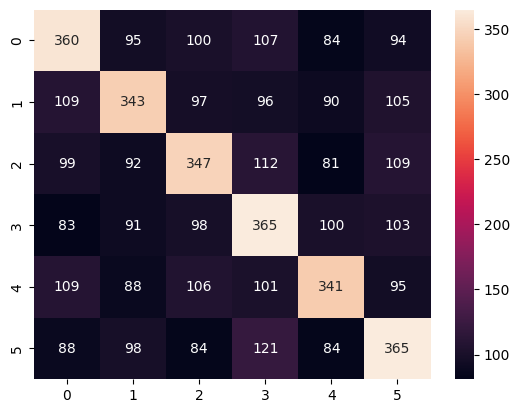

🏃 View run KNN StratifiedKFold=6 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/208c319c3355448bbd54987e18607b13
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.44007936507936507
Precision: 0.44234850589680613
Recall: 0.44007936507936507
F1 Score: 0.440094949180273
AUC Score: 0.7264009353741497
              precision    recall  f1-score   support

       angry       0.40      0.45      0.42       840
        fear       0.48      0.44      0.46       840
       happy       0.42      0.46      0.44       840
     neutral       0.45      0.38      0.42       840
         sad       0.43      0.44      0.43       840
    surprise       0.47      0.47      0.47       840

    accuracy                           0.44      5040
   macro avg       0.44      0.44      0.44      5040
weighted avg       0.44      0.44      0.44      5040



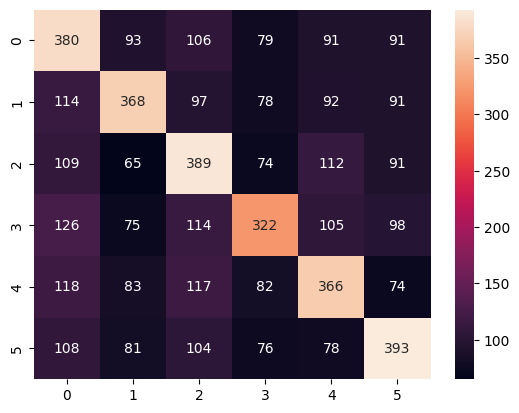

🏃 View run KNN StratifiedKFold=7 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/3aa0c65ed6cf4847a15d5e4b396f4bff
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.4259920634920635
Precision: 0.4267433425585932
Recall: 0.42599206349206353
F1 Score: 0.4258204644588031
AUC Score: 0.7220172902494331
              precision    recall  f1-score   support

       angry       0.46      0.42      0.44       840
        fear       0.41      0.40      0.40       840
       happy       0.40      0.42      0.41       840
     neutral       0.41      0.46      0.43       840
         sad       0.42      0.39      0.41       840
    surprise       0.46      0.47      0.46       840

    accuracy                           0.43      5040
   macro avg       0.43      0.43      0.43      5040
weighted avg       0.43      0.43      0.43      5040



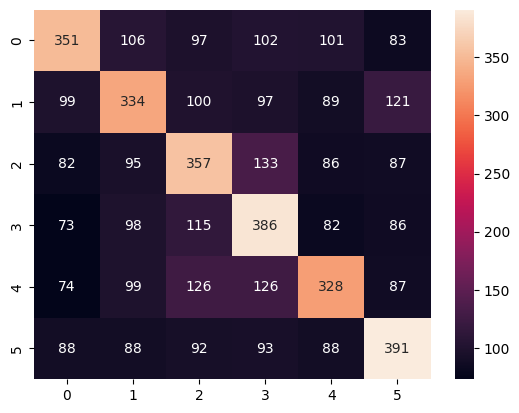

🏃 View run KNN StratifiedKFold=8 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/029ffe7c81c943b0a1ed6dc338ef7fb1
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21
Accuracy: 0.4111111111111111
Precision: 0.4126946821711361
Recall: 0.41111111111111115
F1 Score: 0.41131219194834445
AUC Score: 0.7125943405139834
              precision    recall  f1-score   support

       angry       0.40      0.42      0.41       840
        fear       0.43      0.39      0.41       840
       happy       0.41      0.40      0.40       840
     neutral       0.37      0.43      0.40       840
         sad       0.40      0.39      0.39       840
    surprise       0.46      0.44      0.45       840

    accuracy                           0.41      5040
   macro avg       0.41      0.41      0.41      5040
weighted avg       0.41      0.41      0.41      5040



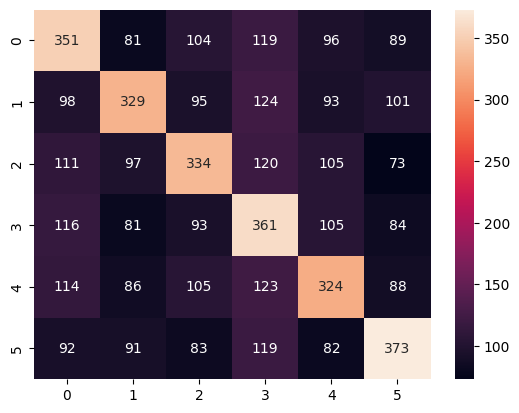

🏃 View run KNN StratifiedKFold=9 at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21/runs/c6d04c63fddb4c5993d41bac49d69bc6
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/21


In [6]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\labels.npy')

N_NEIGHBORS = 3
WEIGHTS = 'distance'
METRIC = 'manhattan'
ALGORITHM = 'auto'
TEST_SIZE = 0.7
RANDOM_STATE = 42
N_SPLITS = 10
SHUFFLE = True

model_params = {
  'n_neighbors': N_NEIGHBORS,
  'weights': WEIGHTS,
  'metric': METRIC,
  'algorithm': ALGORITHM
}

calib_params = {
  'test_size': TEST_SIZE,
  'random_state': RANDOM_STATE
}

kfold_params = {
    'n_splits': N_SPLITS,
    'shuffle': SHUFFLE
}

skf = StratifiedKFold(**kfold_params)
i = 0

for train_idx, test_idx in skf.split(images, labels):
  X_train, X_test = images[train_idx], images[test_idx]
  y_train, y_test = labels[train_idx], labels[test_idx]

  X_calib, X_test, y_calib, y_test = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

  model = KNeighborsClassifier(**model_params)
  model.fit(X_train, y_train)

  calib_model = CalibratedClassifierCV(model, cv="prefit")
  calib_model.fit(X_calib, y_calib)

  predict = calib_model.predict(X_test)
  predict_proba = calib_model.predict_proba(X_test)

  metrics = {
    'accuracy': accuracy_score(y_test, predict),
    'precision': precision_score(y_test, predict, average='macro'),
    'recall': recall_score(y_test, predict, average='macro'),
    'f1': f1_score(y_test, predict, average='macro'),
    'auc_score': roc_auc_score(y_test, predict_proba, multi_class='ovr', average='macro')
  }

  print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nAUC Score: {metrics['auc_score']}")
  report = classification_report(y_test, predict)
  print(report)

  cm = confusion_matrix(y_test, predict)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.savefig('confusion_matrix.png')
  plt.show()

  mlflow.set_experiment("KNN_Model FER2013 224x224")
  mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

  with mlflow.start_run(run_name=f'KNN StratifiedKFold={i}'):
    mlflow.log_artifact('confusion_matrix.png')
    mlflow.log_params(gabor_params)
    mlflow.log_params(calib_params)
    mlflow.log_params(model_params)
    mlflow.log_params(kfold_params)
    mlflow.log_param('floating_point', FLOATING_POINT)
    mlflow.log_param('image_size', IMAGE_SIZE)
    mlflow.log_param('PCA_n_components', N_COMPONENTS)
    mlflow.log_param('gaussian_blur', BLUR)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(
        sk_model=calib_model,
        artifact_path='KNN Model',
        input_example=X_train[:1]
    )
  i = i + 1

## **Testing images shape**

In [43]:
images_ = []
# img = cv.imread(f'facial-emotion-recognition-augmented/disgust/disgust_1022.png', cv.IMREAD_GRAYSCALE)
# img = cv.imread(f'C:\\Users\\vinar\\Downloads\\RAF-DB\\test\\fear\\test_2253_aligned.jpg', cv.IMREAD_GRAYSCALE)
img = cv.imread(f'../happy_2.png', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, IMAGE_SIZE)
img = cv.GaussianBlur(img,BLUR,0)
img = cv.equalizeHist(img)
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

if len(faces) > 0:
    x, y, w, h = faces[0]
    img = img[y:y+h, x:x+w]
else:
    h, w = img.shape[:2]
    crop_size = min(h, w)
    x = (w - crop_size) // 2
    y = (h - crop_size) // 2
    img = img[y:y+crop_size, x:x+crop_size]
    
img = cv.copyMakeBorder(
        img, 
    10, 10, 10, 10,
    cv.BORDER_CONSTANT, 
    value=(0, 0, 0)
    )
    
img = cv.resize(img, IMAGE_SIZE)
img = img / 255.0
img = gabor_filter(img)

img = img.reshape(img.shape[0], -1)
pca = PCA(n_components=N_COMPONENTS_LOCAL)
img = pca.fit_transform(img)
images_.append(img)
images_ = np.array(images_)

images_ = images_.reshape(images_.shape[0], -1)
with open('pca_model.pkl', 'rb') as f:
    loaded_pca = pickle.load(f)
images_ = loaded_pca.transform(images_)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

print(images_.shape)

Explained variance ratio: [6.0501891e-01 1.9623488e-01 1.6038501e-01 1.6716532e-02 1.2215479e-02
 6.5829651e-03 2.2843014e-03 2.1880366e-04 2.1276745e-04 8.2334795e-05
 4.3374072e-05 2.2220327e-06 1.8464320e-06 4.1256934e-07 3.2740294e-07
 9.7836663e-09]
Cumulative explained variance: [0.6050189  0.8012538  0.9616388  0.97835535 0.99057084 0.9971538
 0.9994381  0.9996569  0.9998697  0.999952   0.9999954  0.9999976
 0.99999946 0.9999999  1.0000002  1.0000002 ]
(1, 6)


In [ ]:
# logged_model = 'runs:/5824ce98ca7a4a508f7623fe39881ce1/KNN Model'
logged_model = 'runs:/3aa0c65ed6cf4847a15d5e4b396f4bff/KNN Model'
model = mlflow.pyfunc.load_model(logged_model)

In [44]:
prediction = model.predict(images_)
for p in prediction:
  print(p)

fear


## **Tuning**

### **Without PCA**

In [64]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\labels.npy')

N_NEIGHBORS = [3,5,7,9,11]
WEIGHTS = ['uniform', 'distance']
METRIC = ['minkowski', 'euclidean', 'manhattan']
ALGORITHM = ['auto', 'ball_tree', 'kd_tree', 'brute']

TEST_SIZE = 0.2
RANDOM_STATE = 42

split_params = {
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

model_params = {
    'n_neighbors': N_NEIGHBORS,
    'weights': WEIGHTS,
    'metric': METRIC,
    'algorithm': ALGORITHM
}

scoring = {
    'accuracy': 'accuracy',
    # 'roc_auc': 'roc_auc'
}

X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
# X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

model = KNeighborsClassifier()
grid = GridSearchCV(
    estimator=model, 
    param_grid=model_params,
    scoring=scoring,
    refit='accuracy',
    cv=3,
    verbose=2
)
grid.fit(X_train, y_train)

print(grid.best_estimator_)
print(grid.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=uniform; total time=   0.5s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.5s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.6s
[CV] END algorithm=auto, metric=minkowski, n_neighbors=5, weights=distance; total time= 

d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=3, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=3, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=3, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=5, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=distance; total time=   1.2s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=9, weights=distance; total time=   1.4s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\utils\_response.py", line 211, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "d:\PythonProject\env\Lib\site-packages\sklearn\neighbors\_classification.py", line 259, in pred

[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=distance; total time=   1.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=11, weights=distance; total time=   1.4s
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


d:\PythonProject\env\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.27685764 0.35449653 0.26064236 0.34545139 0.25310764 0.34302083
 0.24833333 0.34069444 0.24175347 0.33831597 0.27685764 0.35449653
 0.26064236 0.34545139 0.25310764 0.34302083 0.24833333 0.34069444
 0.24175347 0.33831597 0.27930556 0.35598958 0.26265625 0.34842014
 0.25359375 0.34527778 0.24909722 0.34168403 0.24223958 0.33932292
 0.27685764 0.35449653 0.26064236 0.34545139 0.25310764 0.34302083
 0.24833333 0.34069444 0.24175347 0.33831597 0.27685764 0.35449653
 0.26064236 0.34545139 0.25310764 0.34302083 0.24833333 0.34069444
 0.24175347 0.33831597 0.27930556 0.35598958 0.26265625 0.34842014
 0.25359375 0.34527778 0.24907986 0.34168403 0.24223958 0.33932292
 0.27685764 0.35449653 0.26064236 0.34545139 0.25310764 0.34302083
 0.24833333 0.34069444 0.24175347 0.33831597 0.27685764 0.35449653
 0.26064236 0.34545139 0.25310764 0.34302083 0.24833333 

### **Using calibration**

In [21]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\combined\\labels.npy')

N_NEIGHBORS = 3
WEIGHTS = 'distance'
METRIC = 'manhattan'
ALGORITHM = 'auto'

TEST_SIZE = 0.2
CALIB_SIZE = 0.5
RANDOM_STATE = 42

split_params = {
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

calib_params = {
    'test_size': CALIB_SIZE,
    'random_state': RANDOM_STATE
}

X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

model_params = {
  'n_neighbors': N_NEIGHBORS,
  'weights': WEIGHTS,
  'metric': METRIC,
  'algorithm': ALGORITHM
}

model = KNeighborsClassifier(**model_params)
model.fit(X_train, y_train)

calib_model = CalibratedClassifierCV(model, cv="prefit")
calib_model.fit(X_calib, y_calib)

predict = calib_model.predict(X_test)
predict_proba = calib_model.predict_proba(X_test)

metrics = {
  'accuracy': accuracy_score(y_test, predict),
  'precision': precision_score(y_test, predict, average='macro'),
  'recall': recall_score(y_test, predict, average='macro'),
  'f1': f1_score(y_test, predict, average='macro'),
  'auc_score': roc_auc_score(y_test, predict_proba, multi_class='ovr', average='macro')
}

print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nROC_AUC Score: {metrics['auc_score']}")
print(classification_report(y_test, predict))

# mlflow.set_experiment("KNN_Model using calibration")
# mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/knn-fer.mlflow")

# with mlflow.start_run(run_name=f'KNN sigma=5'):
#   mlflow.log_params(gabor_params)
#   mlflow.log_params(split_params)
#   mlflow.log_param('calib_test_size', calib_params['test_size'])
#   mlflow.log_param('calib_random_state', calib_params['random_state'])
#   mlflow.log_params(model_params)
#   mlflow.log_metrics(metrics)
#   mlflow.sklearn.log_model(
#       sk_model=calib_model,
#       artifact_path='KNN Model',
#       input_example=X_train[:1]
#   )

Accuracy: 0.5416666666666666
Precision: 0.5417140401524803
Recall: 0.5416666666666667
F1 Score: 0.5416503174348996
ROC_AUC Score: 0.799350162037037
              precision    recall  f1-score   support

       angry       0.54      0.53      0.53      1200
        fear       0.52      0.53      0.53      1200
       happy       0.54      0.53      0.53      1200
     neutral       0.55      0.54      0.54      1200
         sad       0.54      0.54      0.54      1200
    surprise       0.57      0.58      0.58      1200

    accuracy                           0.54      7200
   macro avg       0.54      0.54      0.54      7200
weighted avg       0.54      0.54      0.54      7200



### **Tuning k Value**

In [65]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\labels.npy')

N_NEIGHBORS = range(1,21)
WEIGHTS = 'distance'
METRIC = 'manhattan'
ALGORITHM = 'ball_tree'
TEST_SIZE = 0.5
RANDOM_STATE = 42
N_SPLITS = 10
SHUFFLE = True

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=RANDOM_STATE, test_size=0.2)

def evaluate_knn(k):
    model_params = {
        'n_neighbors': k,
        'weights': WEIGHTS,
        'metric': METRIC,
        'algorithm': ALGORITHM
    }
    model = KNeighborsClassifier(**model_params)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores.mean()

# Parallel execution
scores = Parallel(n_jobs=4)(delayed(evaluate_knn)(k) for k in N_NEIGHBORS)

# Find optimal k
optimal_k = N_NEIGHBORS[scores.index(max(scores))]
print(f"Optimal k: {optimal_k}")

Optimal k: 1


## **Prediction result**

In [52]:
not_same = []

for p, y in zip(predict, y_test):
  if(p != y):
    not_same.append(p)

print(len(not_same))

1120
